In [470]:
import os
import logging
import time
import psycopg2

import pandas as pd
import numpy as np 
from sqlalchemy import create_engine

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
 

def connect_postgres():
    database = os.environ['POSTGRES_DB']
    user = os.environ['POSTGRES_USER']
    password = os.environ['POSTGRES_PASSWORD']
    host = os.environ['POSTGRES_SERVER']
    port = 5432

    exc, conn, engine = None, None, None

    for _ in range(5):
        try:
            conn = psycopg2.connect(
                database=database, user=user, password=password, host=host, port=port)
        except Exception as e:
            logging.warning("Error connecting to postgres, will retry in 3 sec: %s", e)
            time.sleep(3)
            exc = e
        else:
            logging.info("Connected...")
            logging.info("Everything goes well from Postgres, you're a fu*** pro...")
            
            engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                user, password, host, port, database
            ))
            break
    else:
        logging.error("Unable to connect to  %s DB", database)
        raise exc
    
    return [conn, engine]


In [471]:
[conn, engine] = connect_postgres()

INFO:root:Connected...
INFO:root:Everything goes well from Postgres, you're a fu*** pro...


In [538]:
df_iss = pd.read_sql("""
SELECT
	copytransaction.id, code, trans_copy_code_id, trans_tittle_code_id, trans_date_id as date_iss
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date
WHERE
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3743' AND
	trans_type_code IN ('ISS') AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code, id

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [539]:
df_ret = pd.read_sql("""
SELECT
    trans_copy_code_id, trans_tittle_code_id, code, trans_date_id as date_ret
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date
WHERE
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3743' AND
	trans_type_code IN ('RET') AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_copy_code_id, trans_date_id, trans_type_code

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [540]:
df_iss = df_iss.reset_index(drop=True)
df_iss

,id,code,trans_copy_code_id,trans_tittle_code_id,date_iss
0,39355,199120033,16331,10188,19990303
1,293269,199120033,131785,99376,19990525
2,220902,199120033,184745,138918,19971112
3,187137,199120033,185454,139509,19971009
4,581499,199120033,185457,139509,19970820
...,...,...,...,...,...
44908,8802899,201830743,706973,705983,20180207
44909,8938708,201830957,916536,928536,20180207
44910,8764935,201830990,804796,823917,20180224
44911,8919499,201830990,873790,889459,20180220


In [541]:
df_ret = df_ret.reset_index(drop=True)
df_ret

,trans_copy_code_id,trans_tittle_code_id,code,date_ret
0,16331,10188,199120033,19990318
1,131785,99376,199120033,19990526
2,184745,138918,199120033,19971114
3,185454,139509,199120033,19971023
4,185457,139509,199120033,19970919
...,...,...,...,...
45085,706973,705983,201830743,20180209
45086,916536,928536,201830957,20180207
45087,804796,823917,201830990,20180224
45088,873790,889459,201830990,20180220


In [542]:
df_iss = df_iss.astype({col: 'int32' for col in df_iss.select_dtypes('int64').columns})
df_iss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44913 entries, 0 to 44912
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   id                    44913 non-null  int32
 1   code                  44913 non-null  int32
 2   trans_copy_code_id    44913 non-null  int32
 3   trans_tittle_code_id  44913 non-null  int32
 4   date_iss              44913 non-null  int32
dtypes: int32(5)
memory usage: 877.3 KB


In [543]:
df_ret = df_ret.astype({col: 'int32' for col in df_ret.select_dtypes('int64').columns})
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45090 entries, 0 to 45089
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   trans_copy_code_id    45090 non-null  int32
 1   trans_tittle_code_id  45090 non-null  int32
 2   code                  45090 non-null  int32
 3   date_ret              45090 non-null  int32
dtypes: int32(4)
memory usage: 704.7 KB


In [544]:
left2 = df_iss.merge(df_ret, how='left', on=['code','trans_copy_code_id', 'trans_tittle_code_id'])
left2['diff'] = left2['date_ret'] - left2['date_iss']
left2 = left2[left2['diff'] >= 0]
left2 = left2.sort_values(
    ['trans_tittle_code_id', 'diff']
)
left2

,id,code,trans_copy_code_id,trans_tittle_code_id,date_iss,date_ret,diff
1239,5865695,199218080,130217,24,19970424,19970424.0,0.0
10121,15054,199428238,26,24,19990217,19990217.0,0.0
8889,518380,199344105,130217,24,19970611,19970627.0,16.0
8403,5970129,199342359,30,25,20011116,20011116.0,0.0
31921,1895233,200333579,30,25,20040818,20040827.0,9.0
...,...,...,...,...,...,...,...
77806,8956782,201367667,911101,926149,20171108,20171207.0,99.0
89004,9117074,201827246,916536,928536,20180207,20180207.0,0.0
89015,8938708,201830957,916536,928536,20180207,20180207.0,0.0
83267,8895215,201523548,912916,928592,20180126,20180219.0,93.0


In [545]:
left2.columns

Index(['id', 'code', 'trans_copy_code_id', 'trans_tittle_code_id', 'date_iss',
       'date_ret', 'diff'],
      dtype='object')

In [546]:
df = left2.groupby(['code', 'trans_copy_code_id', 'trans_tittle_code_id', 'id'])[[
    'date_iss', 'date_ret', 'diff'
]].first().reset_index()
df

,code,trans_copy_code_id,trans_tittle_code_id,id,date_iss,date_ret,diff
0,199120033,16331,10188,39355,19990303,19990318.0,15.0
1,199120033,131785,99376,293269,19990525,19990526.0,1.0
2,199120033,184745,138918,220902,19971112,19971114.0,2.0
3,199120033,185454,139509,187137,19971009,19971023.0,14.0
4,199120033,185457,139509,581499,19970820,19970919.0,99.0
...,...,...,...,...,...,...,...
43232,201830743,706973,705983,8802899,20180207,20180209.0,2.0
43233,201830957,916536,928536,8938708,20180207,20180207.0,0.0
43234,201830990,804796,823917,8764935,20180224,20180224.0,0.0
43235,201830990,873790,889459,8919499,20180220,20180220.0,0.0


In [547]:
df['ISS'] = pd.to_datetime(df['date_iss'].astype(str), format='%Y%m%d') 
df['RET'] = pd.to_datetime(df['date_ret'].astype(str), format='%Y%m%d')
df['trans_copy_code_id'] = df['trans_copy_code_id'].astype(str)
df['trans_tittle_code_id'] = df['trans_tittle_code_id'].astype(str)
df['duration'] = df['RET'] - df['ISS'] + pd.Timedelta(days=1)
df['duration'] = df['duration'].dt.days
df

,code,trans_copy_code_id,trans_tittle_code_id,id,date_iss,date_ret,diff,ISS,RET,duration
0,199120033,16331,10188,39355,19990303,19990318.0,15.0,1999-03-03,1999-03-18,16
1,199120033,131785,99376,293269,19990525,19990526.0,1.0,1999-05-25,1999-05-26,2
2,199120033,184745,138918,220902,19971112,19971114.0,2.0,1997-11-12,1997-11-14,3
3,199120033,185454,139509,187137,19971009,19971023.0,14.0,1997-10-09,1997-10-23,15
4,199120033,185457,139509,581499,19970820,19970919.0,99.0,1997-08-20,1997-09-19,31
...,...,...,...,...,...,...,...,...,...,...
43232,201830743,706973,705983,8802899,20180207,20180209.0,2.0,2018-02-07,2018-02-09,3
43233,201830957,916536,928536,8938708,20180207,20180207.0,0.0,2018-02-07,2018-02-07,1
43234,201830990,804796,823917,8764935,20180224,20180224.0,0.0,2018-02-24,2018-02-24,1
43235,201830990,873790,889459,8919499,20180220,20180220.0,0.0,2018-02-20,2018-02-20,1


In [548]:
df_new = df.drop(['code', 'trans_copy_code_id', 'date_iss', 'id', 'date_ret', 'diff', 'ISS', 'RET'], axis=1)
df_new = df_new.groupby(['trans_tittle_code_id'])['duration'].agg(
    borrow_days='sum',
    borrow_numbers='count'
).sort_values(
    ['borrow_days', 'borrow_numbers']
).reset_index()
df_new['score'] = df_new['borrow_days'] * df_new['borrow_numbers']
df_new = df_new.set_index('trans_tittle_code_id')
df_new

,borrow_days,borrow_numbers,score
trans_tittle_code_id,,,
10019,1,1,1
100191,1,1,1
100453,1,1,1
100493,1,1,1
100832,1,1,1
...,...,...,...
559092,3050,105,320250
559086,3999,293,1171707
633795,4544,842,3826048


In [549]:
df_new.describe()

,borrow_days,borrow_numbers,score
count,11587.000000,11587.000000,1.158700e+04
mean,42.217917,3.731509,2.260654e+03
std,141.551411,19.323993,7.202172e+04
min,1.000000,1.000000,1.000000e+00
25%,2.000000,1.000000,4.000000e+00
50%,15.000000,1.000000,1.600000e+01
75%,38.000000,2.000000,5.900000e+01
max,6082.000000,1022.000000,6.215804e+06


In [550]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

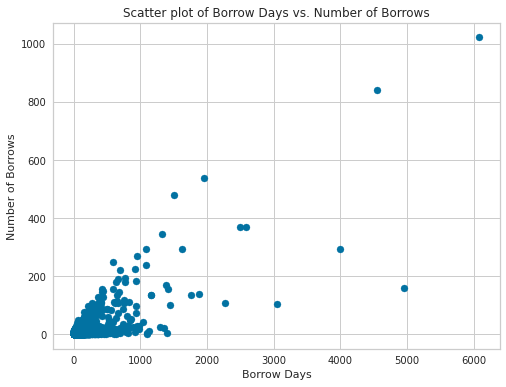

In [551]:
plt.figure(figsize=(8,6))
plt.scatter(df_new.borrow_days, df_new.borrow_numbers)
plt.xlabel('Borrow Days')
plt.ylabel('Number of Borrows')
plt.title('Scatter plot of Borrow Days vs. Number of Borrows')
plt.show()

In [552]:
# Import the sklearn function
from sklearn.preprocessing import StandardScaler

columns = df_new.columns
data_to_standardize = df_new[columns]
scaler = StandardScaler().fit(data_to_standardize)

# Standardize the columns.
standardized_data = df_new.copy()
standardized_columns = scaler.transform(data_to_standardize)
standardized_data[columns] = standardized_columns

standardized_data

,borrow_days,borrow_numbers,score
trans_tittle_code_id,,,
10019,-0.291199,-0.141359,-0.031376
100191,-0.291199,-0.141359,-0.031376
100453,-0.291199,-0.141359,-0.031376
100493,-0.291199,-0.141359,-0.031376
100832,-0.291199,-0.141359,-0.031376
...,...,...,...
559092,21.249607,5.240783,4.415377
559086,27.954174,14.970042,16.238113
633795,31.804532,43.381546,53.094435


In [553]:
standardized_data.describe()

,borrow_days,borrow_numbers,score
count,1.158700e+04,11587.000000,1.158700e+04
mean,1.962317e-17,0.000000,-4.905793e-18
std,1.000043e+00,1.000043,1.000043e+00
min,-2.911995e-01,-0.141359,-3.137597e-02
25%,-2.841346e-01,-0.141359,-3.133432e-02
50%,-1.922912e-01,-0.141359,-3.116769e-02
75%,-2.979906e-02,-0.089608,-3.057063e-02
max,4.267031e+01,52.696793,8.627691e+01


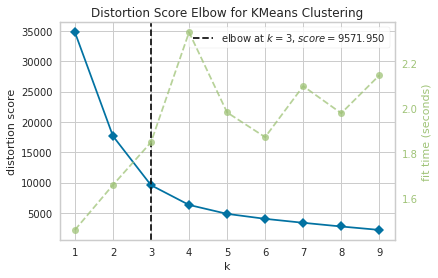

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [554]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(init='k-means++', random_state=540)
visualizer = KElbowVisualizer(km, k=(1,10))
 
visualizer.fit(standardized_data)
visualizer.show()

In [555]:
# Train a Kmeans instance
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=540)
kmeans.fit(standardized_data)
clusters = kmeans.predict(standardized_data)
df_new['cluster'] = clusters


df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('int64').columns})
df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('float64').columns})
df_new = df_new.astype({col: 'int32' for col in df_new.select_dtypes('bool').columns})

df_new

,borrow_days,borrow_numbers,score,cluster
trans_tittle_code_id,,,,
10019,1,1,1,0
100191,1,1,1,0
100453,1,1,1,0
100493,1,1,1,0
100832,1,1,1,0
...,...,...,...,...
559092,3050,105,320250,2
559086,3999,293,1171707,2
633795,4544,842,3826048,1


In [556]:
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

pca = PCA(n_components=2)

reduced_X = pd.DataFrame(pca.fit_transform(standardized_data), columns=["PC1", "PC2"])
reduced_X

,PC1,PC2
0,-0.266265,0.186725
1,-0.266265,0.186725
2,-0.266265,0.186725
3,-0.266265,0.186725
4,-0.266265,0.186725
...,...,...
11582,17.626542,-12.737618
11583,33.967352,-9.245971
11584,74.154782,14.367114
11585,30.524355,-18.516623


In [557]:
reduced_X['cluster'] = clusters
reduced_X

,PC1,PC2,cluster
0,-0.266265,0.186725,0
1,-0.266265,0.186725,0
2,-0.266265,0.186725,0
3,-0.266265,0.186725,0
4,-0.266265,0.186725,0
...,...,...,...
11582,17.626542,-12.737618,2
11583,33.967352,-9.245971,2
11584,74.154782,14.367114,1
11585,30.524355,-18.516623,2


/opt/app/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


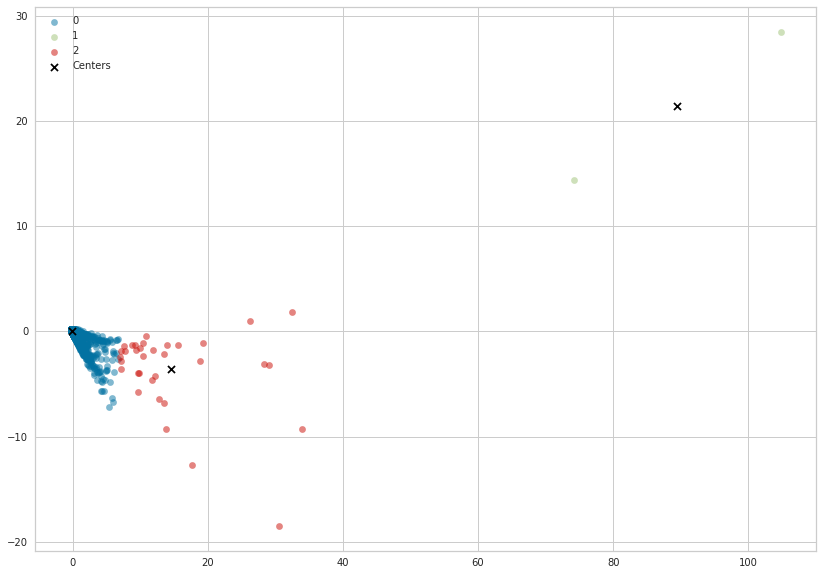

In [558]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

reduced_centers = pca.transform(kmeans.cluster_centers_)

for cluster in range(0, n_clusters):
    plt.scatter(
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC1'],
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC2'], 
        label=cluster, alpha=0.5, s=40
    )

plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker='x', label='Centers', c="black", s=50)
plt.legend()
plt.show()

In [559]:
df_new['cluster'].value_counts()

0    11551
2       34
1        2
Name: cluster, dtype: int64

In [572]:
df_new[df_new['cluster'] == 2].sort_values('score', ascending=False).head(20)

,borrow_days,borrow_numbers,score,cluster
trans_tittle_code_id,,,,
559086,3999,293,1171707,2
358787,1960,539,1056440,2
584102,2586,370,956820,2
34188,2487,369,917703,2
542580,4955,158,782890,2
463593,1511,481,726791,2
430970,1620,292,473040,2
135202,1332,346,460872,2
559092,3050,105,320250,2
